In [1]:
from math import sqrt
import numpy as np
import matplotlib.path as mpl_path
import matplotlib.pyplot as plt
import pre_processing as pp
import csv
import pandas as pd
import tensorflow as tf

## Classes and methods for GridPoint-manipulation

In [2]:
"""
|---------------------------------------------------
|       CONSTANTS
|---------------------------------------------------
"""

GRID_RESOLUTION = 20
PATCH_SIZE = 2
VAL_RANGE = 2.86
GRID_SCORE_IF_OUTSIDE_CONTOUR = 1.5


"""
|---------------------------------------------------
|       CLASSES AND METHODS
|---------------------------------------------------
"""

class GridPoint():
    def __init__(self, pid: int, x: float, y: float, score: float = 0):
        self._pid = pid
        self._x = x
        self._y = y
        self._score = score
        self._neighbours = []

    def get_coordinates(self):
        return (self._x, self._y)

    @property
    def neighbours(self):
        return self._neighbours

    @neighbours.setter
    def neighbours(self, neighbours: list):
        # print(f"set grid point ({self._x}, {self._y}) neigbours to: {neighbours}")
        self._neighbours = neighbours

    @property
    def x(self):
        return self._x
    
    @property
    def y(self):
        return self._y

    @property
    def pid(self):
        return self._pid

    @property
    def score(self):
        return self._score

    @score.setter
    def score(self, score):
        #print(f"set grid point ({round(self._x, 3)}, {round(self._y, 3)}) to score: {round(score, 3)}")
        self._score = score

    def __repr__(self):
        return (f"{round(self._score, 3)}")
        # return (f"({round(self._x, 3)}, {round(self._y, 3)}, {self._score})")



def generate_point_grid():
    """
    |   Output: 
    |       - a point grid, G, of resolution 20x20 filled with GridPoint-objects with coordinates
    |         in the range ~[-1.3, -1.3] -> [1.3, 1.3]. 
    |        
    |   The grid is structured as a list of list where both the first row and column correspond         
    |   to the GridPoint with the lowest value (and vice verse for the last row and column).
    |
    |   Padding is added intermittently to simplify the generation of neighbours of a GridPoint.     
    |   These padding points are removed before returning the list.
    """

    # Create list of coordinates from 0->VAL_RANGE, then shift it to be mirrored on 0.
    # Grid resolution + 2 for padding
    x_coordinates = np.linspace(0.0, VAL_RANGE, num=GRID_RESOLUTION+2, endpoint=True) - VAL_RANGE/2
    y_coordinates = np.linspace(0.0, VAL_RANGE, num=GRID_RESOLUTION+2, endpoint=True) - VAL_RANGE/2
    
    point_grid = []
    point_id = 0
    for y in y_coordinates:
        point_grid_row = []
        for x in x_coordinates:
            point_grid_row.append(GridPoint(point_id, x, y))
            point_id+=1
        point_grid.append(point_grid_row)

    # Sets neighbours for each grid point (not including padding)
    for y in range(1, len(point_grid)-1):
        for x in range(1, len(point_grid)-1):
            neighbour_list = []
            neighbour_list.append(point_grid[y-1][x-1])     # bottom left
            neighbour_list.append(point_grid[y-1][x])       # bottom
            neighbour_list.append(point_grid[y-1][x+1])     # bottom right
            neighbour_list.append(point_grid[y][x+1])       # right
            neighbour_list.append(point_grid[y+1][x+1])     # top right
            neighbour_list.append(point_grid[y+1][x])       # top
            neighbour_list.append(point_grid[y+1][x-1])     # top left
            neighbour_list.append(point_grid[y][x-1])       # left
            point_grid[y][x].neighbours = neighbour_list


    # Removes padding points from output by removing points that were not given neighbours
    cleaned_point_grid = []
    for row in point_grid:
        cleaned_row = [x for x in row if x.neighbours]
        # Completely empty rows (first and last) are also removed
        if cleaned_row:
            cleaned_point_grid.append(cleaned_row)
    
    return cleaned_point_grid


def calculate_score(point_grid, internal_nodes, contour_points) -> None:
    """
    |   Input: 
    |       - a point grid (list of lists) 
    |       - coordinates of the internal nodes in the mesh (list of tuples)
    |       - coordinates of the contour vertices (list of tuples)
    |
    |   For each GridPoint in the point grid, we iterate over the internal nodes and calculate
    |   the euclidean distances (scores) to each internal node. The shortest distance is the
    |   score of the GridPoint. 
    |
    |   If a GridPoint is not inside the contour, we set it's score to an arbitrary penalty. 
    |
    |
    """
    # Define contour (for finding points inside)
    contour_path = mpl_path.Path(contour_points)

    for row in point_grid:
        for point in row:
            score = GRID_SCORE_IF_OUTSIDE_CONTOUR
            point_coordinates = point.get_coordinates()

            if contour_path.contains_point(point_coordinates):
                for internal_node in internal_nodes:
                    distance = sqrt((point_coordinates[0]-internal_node[0])
                                    ** 2 + (point_coordinates[1] - internal_node[1])**2)
                    if distance < score:
                            score = distance
            if score < 1.0:
                point.score = score**2
            else:
                point.score = score
            


def generate_patches(point_grid):
    """
    |   Generates patches of the given patch size (NxN) containing the GridPoint-objects
    |   of the patch.
    """

    patches = []
    for row in range(0, GRID_RESOLUTION, PATCH_SIZE):
        for col in range(0, GRID_RESOLUTION, PATCH_SIZE):
            p1 = point_grid[row][col]
            p2 = point_grid[row][col+1]
            p3 = point_grid[row+1][col]
            p4 = point_grid[row+1][col+1]
            
            patches.append([p1, p2, p3, p4])

    return patches


def generate_patch_training_dataset_from_contour(contour, point_grid):
    """
    |   Input:
    |       - coordinates of a contour
    |       - a point grid
    |
    |   Output: 
    |       - a list of list where each row of the list contains data for one patch:
    |           - the input contour coordinates [x1 y1 ... xn yn], 
    |           - the coordinates of the corners of the patch [x1 y1 ... x4 y4]
    |           - the grid scores of the corners of the patch [gs1 gs2 gs3 gs4]
    """

    patches = generate_patches(point_grid)

    dataset = []
    for patch in patches:
        patch_data = []
        
        patch_coordinates = [coordinate for point in patch for coordinate in point.get_coordinates()]
        patch_grid_scores = [point.score for point in patch]

        patch_data.extend(contour)
        patch_data.extend(patch_coordinates)
        patch_data.extend(patch_grid_scores)

        dataset.append(patch_data)

    return dataset


def generate_patch_collection(dataset):
    """
    !!! only functional for 6gons with 2 internal nodes !!!
    |   Input:
    |       - a pandas.DataFrame where each row consists of:
    |           - the coordinates of a contour
    |           - the coordinates of a set number of internal nodes
    |
    |   Output: 
    |       - a list of list where the rows contains all the "patch data" from all the given contours
    |
    |   Used for csv generation; feeds into write_patch_collection_to_csv.
    |
    """
    
    patch_collection = []   
    for row in dataset.values.tolist():
        # For a 6-gon with 2 internal nodes, a row is structured like:
        # contour_coordinates [x1 -> y6] (12 values)
        # internal_node_count = 2 (1 value)
        # internal_node_coordinates [x1 -> y2] (4 values)
        contour_coordinates_flat_list = row[:12]
        internal_nodes_list = row[-4:]

        # Turn flat list into list of tuples (used in calculate_score)
        contour = list(zip(contour_coordinates_flat_list[::2], contour_coordinates_flat_list[1::2]))
        internal_nodes = list(zip(internal_nodes_list[::2], internal_nodes_list[1::2]))

        point_grid = generate_point_grid()
        calculate_score(point_grid, internal_nodes, contour)

        contour_patches = generate_patch_training_dataset_from_contour(contour_coordinates_flat_list, point_grid)

        patch_collection.extend(contour_patches)
        
    return patch_collection

# Method for writing a patch collection to csv
def write_patch_collection_to_csv(patch_collection) -> None:
    with open(f"data/patches-dataset-oneandhalf-penalty-inside-bonus.csv", "w", newline="") as file:
        writer = csv.writer(file)
        header = ['x1', 'y1',
                'x2', 'y2',
                'x3', 'y3',
                'x4', 'y4',
                'x5', 'y5',
                'x6', 'y6',
                'gx1', 'gy1',
                'gx2', 'gy2',
                'gx3', 'gy3',
                'gx4', 'gy4',
                'sg1', 'sg2',
                'sg3', 'sg4'
        ]
        writer.writerow(header)
        for row in patch_collection:
            writer.writerow(row)


def generate_internal_nodes_from_grid_score(point_grid, target_internal_node_count: int) -> list:
    """
    |   Input:
    |       - point grid with calculated/precited grid scores
    |       - target number of internal nodes within a contour,
    | 
    |   Output:
    |       - a list of the (x, y)-coordinates of the internal nodes interpolated from the grid scores.
    |
    |-------------------------------
    |   Interpolation
    |-------------------------------
    |   The interpolation process is based on two ideas. Given a grid point with minimal score, we assume;
    |    1. The actual point lies within the quadrant that contains the diagonal neighbour with the lowest score.
    |    2. The location of the actual point within the quadrant can be approximated using a procedure similar
    |       to how one would find the center of mass in mechanics. We weight each node in the quadrant using the 
    |       inverse square of their grid scores.
    """
    internal_nodes = []
    point_grid = [point for row in point_grid for point in row]  # flattened point grid

    # The quadrants-dictionary contains the indices of all the points in a 
    # quadrant given the index of a "diagonal" neighbour to the GridPoint-object.
    # 6  5  4
    # 7  P  3
    # 0  1  2
    quadrants = {
        0: [7, 0, 1],
        2: [1, 2, 3],
        4: [3, 4, 5],
        6: [5, 6, 7],
    }

    while len(internal_nodes) < target_internal_node_count:

        min_grid_point = min(point_grid, key=lambda x: x.score)
        neighbours = min_grid_point.neighbours
        
        # Decides which quadrant the point is located in. 
        lowest_score_diagonal_node = neighbours[0]
        lowest_score_diagonal_node_index = 0
        for i in [2, 4, 6]:
            if neighbours[i].score < lowest_score_diagonal_node.score:
                lowest_score_diagonal_node = neighbours[i]
                lowest_score_diagonal_node_index = i

        
        # Generates a list containing the grid points in the quadrant.
        gridpoint_quadrant = [neighbours[i] for i in quadrants[lowest_score_diagonal_node_index]]
        gridpoint_quadrant.append(min_grid_point)

        # Calculate weights of each node in the quadrant.
        total_score = sum(point.score**16 for point in gridpoint_quadrant)
        weights = np.array([(total_score-point.score**16)/total_score for point in gridpoint_quadrant])
        total_weight = sum(weights)

        # Interpolation
        interpolated_x = 0
        interpolated_y = 0
        for i, p in enumerate(gridpoint_quadrant):
            interpolated_x += weights[i]*p.x
            interpolated_y += weights[i]*p.y
        interpolated_x /= total_weight
        interpolated_y /= total_weight

        internal_nodes.append((interpolated_x, interpolated_y))

        # We remove the current minimum GridPoint and all its neighbours from the point grid.
        if len(internal_nodes) != target_internal_node_count:
            points_to_exclude_by_id = {min_grid_point.pid}
            points_to_exclude_by_id.update([point.pid for point in neighbours])
            
            point_grid[:] = [point for point in point_grid if point.pid not in points_to_exclude_by_id]

    return internal_nodes


# Prediction pipeline for case: 6-gon with two internal nodes


meshed contour has 1.0 internal nodes!
meshed contour has 1.0 internal nodes!
meshed contour has 2.0 internal nodes!


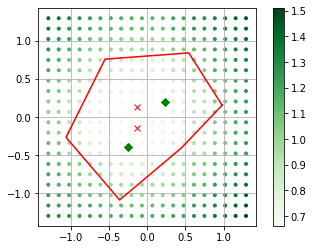

In [9]:

def predict_internal_node_count() -> int:
    return 2


# Pre-processing method for nn2. 
def prediction_pipeline_nn2(contour, internal_node_count):

    # Predict internal node count using neural network 1.
    internal_node_count = predict_internal_node_count()

    # Build point grid
    point_grid = generate_point_grid()
    patches = generate_patches(point_grid)

    # Pre-process contour with procrustes superimposition
    transformed_contour = pp.procrustes(contour)['transformed_contour'] 
    transformed_contour_data = [coordinate for point in transformed_contour for coordinate in point]

    # Load model from file
    model = tf.keras.models.load_model('model/six_edge_two_internal_onehalf_penalty_inside_bonus')
    # model.summary()

    # Get patch data
    for patch in patches:
        patch_data = [coordinate for point in patch for coordinate in point.get_coordinates()]

        # Define prediction data
        features = np.append(transformed_contour, patch_data)
        prediction_data = np.expand_dims(features, axis=0)

        # Predict
        prediction_result = model(prediction_data).numpy()

        # Write predicted score to the point grid
        for i, p in enumerate(patch):
            p.score = prediction_result[0][i] 

    return point_grid


# Naive way of only checking the results on contours that the reference mesher would insert two points into
meshed_internal_node_count = -1
internal_node_count = predict_internal_node_count()

while meshed_internal_node_count != internal_node_count:
    contour = pp.create_random_ngon(6)
    transformed_contour = pp.procrustes(contour)['transformed_contour']
    
    predicted_point_grid = prediction_pipeline_nn2(transformed_contour, internal_node_count)
    internal_nodes = generate_internal_nodes_from_grid_score(predicted_point_grid, internal_node_count)


    meshed_contour = pp.mesh_contour(transformed_contour, 0.6)
    meshed_internal_points = meshed_contour[-4:]
    meshed_internal_node_count = int(meshed_contour[13])
    print(f"meshed contour has {meshed_contour[13]} internal nodes!")


"""
|-------------------------
|       PLOTTING
|-------------------------
"""
flat_pgp = [point for row in predicted_point_grid for point in row]

pgp_x = [p.x for p in flat_pgp]
pgp_y = [p.y for p in flat_pgp]
pgp_s = [p.score for p in flat_pgp]

# Plot predicted points (green)
plt.grid(b=True)
plt.plot([x[0] for x in internal_nodes], [y[1] for y in internal_nodes], 'rx')
plt.plot(meshed_internal_points[0], meshed_internal_points[1], 'gD')
plt.plot(meshed_internal_points[2], meshed_internal_points[3], 'gD')

# Plot transformed contour
pp.plot_polygon(transformed_contour, style='r')

# Plot point grid
plt.scatter(pgp_x, pgp_y, c=pgp_s, cmap=plt.cm.Greens, marker='.')
plt.colorbar()

plt.gca().set_aspect('equal')

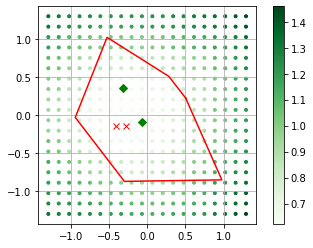

In [8]:
# Try to scatter plot grid points to see whats going on
flat_pgp = [point for row in predicted_point_grid for point in row]

pgp_x = [p.x for p in flat_pgp]
pgp_y = [p.y for p in flat_pgp]
pgp_s = [p.score for p in flat_pgp]

# Plot predicted points (green)
plt.grid(b=True)
plt.plot([x[0] for x in internal_nodes], [y[1] for y in internal_nodes], 'rx')
plt.plot(meshed_internal_points[0], meshed_internal_points[1], 'gD')
plt.plot(meshed_internal_points[2], meshed_internal_points[3], 'gD')

# Plot transformed contour
pp.plot_polygon(transformed_contour, style='r')

# Plot point grid
plt.scatter(pgp_x, pgp_y, c=pgp_s, cmap=plt.cm.Greens, marker='.')
plt.colorbar()

plt.gca().set_aspect('equal')



In [ ]:
# Test data
point_grid_test = generate_point_grid()
test_points = [(-0.123, -0.234), (0.123, 0.234), (0.4, -0.2)]
transformed_contour = pp.procrustes(pp.create_random_ngon(6))['transformed_contour']
calculate_score(point_grid_test, test_points, transformed_contour)

internal_nodes = generate_internal_nodes_from_grid_score(point_grid_test, 3)

# Try to scatter plot grid points to see whats going on
flat_pgp = [point for row in point_grid_test for point in row]

pgp_x = [p.x for p in flat_pgp]
pgp_y = [p.y for p in flat_pgp]
pgp_s = [p.score for p in flat_pgp]

# Plot predicted points (green)
plt.grid(b=True)
plt.plot([x[0] for x in test_points], [y[1] for y in test_points], 'gD')
plt.plot([x[0] for x in internal_nodes], [y[1] for y in internal_nodes], 'rx')

# Plot transformed contour
pp.plot_polygon(transformed_contour, style='r')

# Plot point grid
plt.scatter(pgp_x, pgp_y, c=pgp_s, cmap=plt.cm.Greens, marker='.')
plt.colorbar()

plt.gca().set_aspect('equal')



# Creating dataset for patches

In [6]:
# 1. Read meshed contours to dataframe
df = pd.read_csv('data/6-gon-mesh-with-internal-nodes.csv')

# 2. Separate based on internal nodes added. We choose 2 as it has the highest incidence.
#    -> Remove empty columns with dropna.
#    -> Remove target_edge_length column (experiment)
df_two_internal = df[df.internal_node_count == 2.0].dropna(axis=1, how='all')
df_two_internal = df_two_internal.drop("target_edge_length", axis=1)

# 3. Different 'target_edge_length's can produce same mesh.
#    -> Since we remove differentiation on target_edge_length, we should also
#    -> remove these duplicates. 
df_two_internal_no_dupes = df_two_internal.drop_duplicates()

dataset = df_two_internal_no_dupes
write_patch_collection_to_csv(generate_patch_collection(dataset))


# Neural network 2: predicting internal node positions (or rather: predict grid score)

For now we only train the network on the dataset with:
- 6 edges
- 2 internal nodes
- 100 2x2 patches


7.8731
Epoch 209/300
261/261 - 2s - loss: 0.2911 - mean_absolute_error: 0.4740 - mean_absolute_percentage_error: 936.7892 - val_loss: 0.2057 - val_mean_absolute_error: 0.4124 - val_mean_absolute_percentage_error: 834.6073
Epoch 210/300
261/261 - 2s - loss: 0.2925 - mean_absolute_error: 0.4745 - mean_absolute_percentage_error: 1030.7122 - val_loss: 0.2055 - val_mean_absolute_error: 0.4117 - val_mean_absolute_percentage_error: 835.5118
Epoch 211/300
261/261 - 2s - loss: 0.2906 - mean_absolute_error: 0.4728 - mean_absolute_percentage_error: 939.3644 - val_loss: 0.2065 - val_mean_absolute_error: 0.4142 - val_mean_absolute_percentage_error: 833.0068
Epoch 212/300
261/261 - 2s - loss: 0.2917 - mean_absolute_error: 0.4740 - mean_absolute_percentage_error: 933.5864 - val_loss: 0.2068 - val_mean_absolute_error: 0.4145 - val_mean_absolute_percentage_error: 833.7415
Epoch 213/300
261/261 - 2s - loss: 0.2904 - mean_absolute_error: 0.4729 - mean_absolute_percentage_error: 913.7841 - val_loss: 0.206

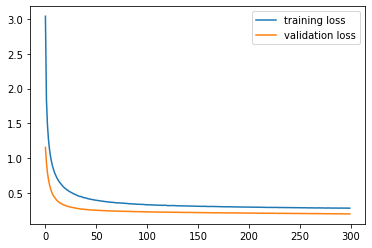

In [7]:
# packages
from tensorflow.keras import layers, metrics
import sklearn.utils
import datetime
import os

#  %load_ext tensorboard

# Parameters
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-2
EPOCHS = 300
BATCH_SIZE = 256

patches = pd.read_csv('data/patches-dataset-oneandhalf-penalty-inside-bonus.csv')
# patches = pd.read_csv('data/patches-dataset-test.csv')

# Split dataset into 70/15/15 training/validation/test
patches_train = patches.sample(frac=0.85, random_state=0)
patches_test = patches.drop(patches_train.index)

# Shuffle dataset
patches_train = sklearn.utils.shuffle(patches_train)
patches_test = sklearn.utils.shuffle(patches_test)

# Split dataset into features and labels; last 4 columns 
# (predicted grid scores of a patch) are the labels.
train_features = patches_train.iloc[:, :-4]
train_labels = patches_train.iloc[:, -4:]

test_features = patches_train.iloc[:, :-4]
test_labels = patches_train.iloc[:, -4:]

model = tf.keras.Sequential([
    tf.keras.Input(shape=(20,)),
    layers.BatchNormalization(),

    layers.Dense(20),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(20),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(4),
])

model.summary()
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(
                  learning_rate=LEARNING_RATE,
                  decay=WEIGHT_DECAY,
              ),
              metrics=[
                  metrics.mean_absolute_error,
                  metrics.mean_absolute_percentage_error
              ]
              )

# tensorboard support
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# %tensorboard --logdir logs

history = model.fit(train_features,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=0.18,
                    verbose=2,
                    )

# Evaluate the model
train_acc, train_abs_err, train_abs_pct_err = model.evaluate(
    train_features, train_labels, verbose=0)
test_acc, test_abs_err, test_abs_pct_err = model.evaluate(
    test_features, test_labels, verbose=0)
print('Training data loss: %.3f, Test data loss: %.3f' %
        (train_acc, test_acc))
print(f"Training mean absolute and percentage error: {(round(train_abs_err, 3), train_abs_pct_err)}")
print(f"Test mean absolute and percentage error: {(test_abs_err, test_abs_pct_err)}")

# plot history
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()





In [8]:
model.save('model/six_edge_two_internal_onehalf_penalty_inside_bonus')


INFO:tensorflow:Assets written to: model/six_edge_two_internal_onehalf_penalty_inside_bonus\assets
